In [2]:
#Find the threshold for the percentile
import filtering  
df = filtering.moses_to_df("data/en-si/GNOME.en-si.en", "data/en-si/GNOME.en-si.si", "english", "sinhala")
e1 = filtering.to_multilingual_embedding("english", df["english"], "labse")
e2 = filtering.to_multilingual_embedding("sinhala", df["sinhala"], "labse")
ss = filtering.find_similarity_score(e1, e2)

/home/tanmay/miniconda3/envs/thesis_wsl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(array([ 5.,  1.,  7.,  6.,  8.,  7., 11., 12.,  5.,  8., 15., 13., 12.,
         8., 15., 13., 13., 19., 12., 17., 18., 22., 19., 23., 41., 39.,
        33., 40., 47., 59., 38., 46., 63., 51., 68., 66., 51., 37., 25.,
        33., 14., 15., 11., 10.,  8.,  2.,  7.,  2.,  2.,  2.]),
 array([-0.00828623, -0.00233907,  0.0036081 ,  0.00955526,  0.01550243,
         0.0214496 ,  0.02739676,  0.03334393,  0.03929109,  0.04523826,
         0.05118542,  0.05713259,  0.06307976,  0.06902692,  0.07497409,
         0.08092125,  0.08686842,  0.09281558,  0.09876275,  0.10470992,
         0.11065708,  0.11660425,  0.12255141,  0.12849858,  0.13444574,
         0.14039291,  0.14634008,  0.15228724,  0.15823441,  0.16418157,
         0.17012874,  0.17607591,  0.18202307,  0.18797024,  0.1939174 ,
         0.19986457,  0.20581173,  0.2117589 ,  0.21770607,  0.22365323,
         0.2296004 ,  0.23554756,  0.24149473,  0.24744189,  0.25338906,
         0.25933623,  0.26528339,  0.27123056,  0.27717772,

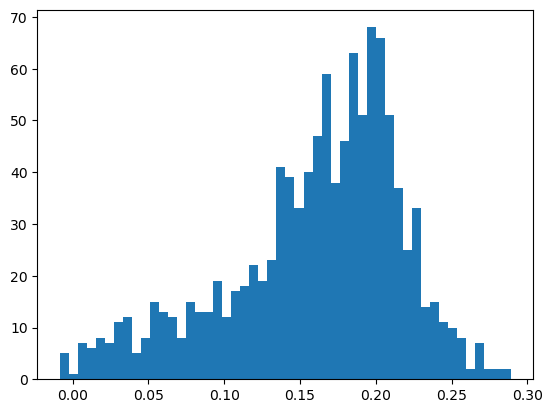

In [3]:
import matplotlib.pyplot as plt
plt.hist(ss, bins=50)

In [4]:
#Find threshold for the length preprocessing 
df_GNOME = filtering.moses_to_df("data/en-si/GNOME.en-si.en", "data/en-si/GNOME.en-si.si", "english", "sinhala")
df_Ubuntu = filtering.moses_to_df("data/en-si/Ubuntu.en-si.en", "data/en-si/Ubuntu.en-si.si", "english", "sinhala")
df_KDE4 = filtering.moses_to_df("data/en-si/KDE4.en-si.en", "data/en-si/KDE4.en-si.si", "english", "sinhala")

In [13]:
def plot_length_ratios(df):
    import numpy as np
    ratios = []
    for s1, s2 in zip(df["english"], df["sinhala"]):
        ratios.append(float(len(s1)/len(s2)))
    plt.hist(ratios, bins=50)
    print(np.percentile(ratios, 95))

2.71785714285714


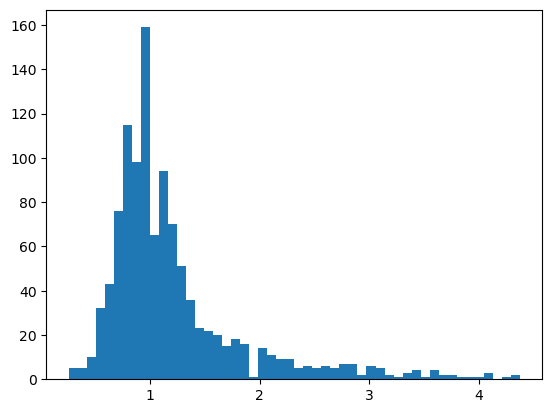

In [14]:
plot_length_ratios(df_GNOME)

1.4273809523809529


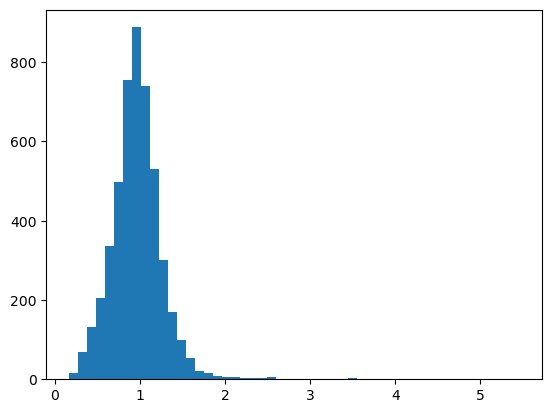

In [16]:
plot_length_ratios(df_KDE4)

1.5


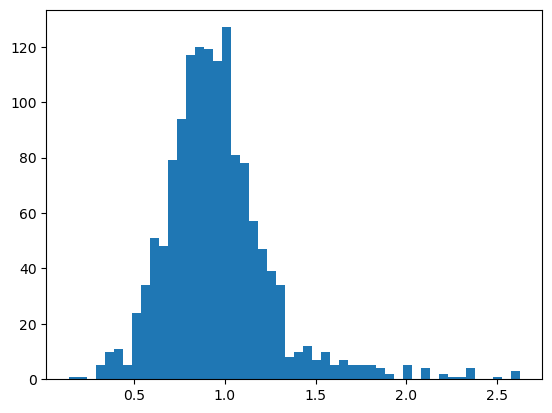

In [15]:
plot_length_ratios(df_Ubuntu)